# 🌸 Seasonality Analysis

**Objectif**: Analyser les variations saisonnières des ratings et découvrir les cycles cachés de satisfaction utilisateurs.

## 🔍 Questions exploratoires:
- L'humeur saisonnière influence-t-elle les évaluations ?
- Quels sont les "mois maudits" vs "mois bénis" pour les ratings ?
- Y a-t-il des patterns cachés (6 mois, trimestre) ?
- Certains mois sont-ils systématiquement problématiques ?
- Quelles saisons génèrent le plus de controverse ?

In [3]:
# Imports et chargement utilitaires
import sys
from pathlib import Path

# Import du module Python utilitaire (plus robuste que exec)
sys.path.append(str(Path("..").resolve()))

# Imports spécifiques analyses saisonnières
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import kruskal, f_oneway
from scipy.fft import fft, fftfreq
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# 🎯 Chargement des fonctions utilitaires depuis le module Python
from data_utils import *

print("✅ Imports terminés - Prêt pour l'analyse Seasonality!")

✅ Imports terminés - Prêt pour l'analyse Seasonality!


In [4]:
# Chargement et préparation des données
print("🔄 Chargement des données...")
df_clean = load_clean_interactions()
print(f"✅ Données chargées: {df_clean.shape}")

# Vérification des colonnes saisonnières
print(f"\n📊 Colonnes disponibles:")
print(f"Season: {'season' in df_clean.columns}")
print(f"Month: {'month' in df_clean.columns}")
print(f"Year: {'year' in df_clean.columns}")

# Aperçu rapide des saisons
print(f"\n🌸 Répartition par saisons:")
seasonal_split = df_clean.group_by("season").agg([
    pl.len().alias("count"),
    pl.col("rating").mean().alias("mean_rating"),
    pl.col("rating").std().alias("std_rating")
]).sort("mean_rating", descending=True)
display(seasonal_split.to_pandas())

# Aperçu mensuel
print(f"\n📅 Aperçu mensuel:")
monthly_split = df_clean.group_by("month").agg([
    pl.len().alias("count"),
    pl.col("rating").mean().alias("mean_rating")
]).sort("month")
display(monthly_split.to_pandas())

🔄 Chargement des données...
✅ Données chargées: (1132367, 13)

📊 Colonnes disponibles:
Season: True
Month: True
Year: True

🌸 Répartition par saisons:
✅ Données chargées: (1132367, 13)

📊 Colonnes disponibles:
Season: True
Month: True
Year: True

🌸 Répartition par saisons:


,season,count,mean_rating,std_rating
0,Summer,277149,4.434553,1.241816
1,Spring,281632,4.419327,1.254580
2,Autumn,275882,4.403310,1.268613
3,Winter,297704,4.388382,1.291186



📅 Aperçu mensuel:


,month,count,mean_rating
0,1,109814,4.405595
1,2,92331,4.385429
2,3,98245,4.382992
3,4,93883,4.431633
4,5,89504,4.446304
5,6,97027,4.471364
6,7,91356,4.417291
7,8,88766,4.412083
8,9,89063,4.410092
9,10,95018,4.412606


## 🌸 Analyse 1: Variations Saisonnières des Ratings

**Objectif exploratoire**: Découvrir si certaines saisons rendent les gens plus/moins satisfaits  
**Question business**: L'humeur saisonnière influence-t-elle les évaluations ?  
**Découverte attendue**: Hiver = ratings plus bas, été = plus généreux ?

In [ ]:
# Préparation DataFrame seasonal_ratings
seasonal_ratings = df_clean.group_by("season").agg([
    pl.col("rating").mean().alias("mean_rating"),
    pl.col("rating").median().alias("median_rating"),
    pl.col("rating").std().alias("std_rating"),
    pl.len().alias("n_interactions"),
    pl.col("rating").quantile(0.25).alias("q25"),
    pl.col("rating").quantile(0.75).alias("q75")
]).to_pandas()

# Ordre logique des saisons
season_order = ["Spring", "Summer", "Autumn", "Winter"]
seasonal_ratings = seasonal_ratings.set_index('season').loc[season_order].reset_index()

print("🌸 Statistiques par saisons:")
display(seasonal_ratings)

# Test ANOVA
season_groups = [df_clean.filter(pl.col("season") == season)["rating"].to_pandas().tolist() 
                for season in season_order]
f_stat, p_anova = f_oneway(*season_groups)

print(f"\n🧪 Test ANOVA:")
print(f"F-statistique: {f_stat:.3f}")
print(f"P-valeur: {p_anova:.4f}")
print(f"Interprétation: {'Différences significatives entre saisons' if p_anova < 0.05 else 'Pas de différences significatives'}")

# Test robuste Kruskal-Wallis
h_stat, p_kruskal = kruskal(*season_groups)
print(f"\n🧪 Test Kruskal-Wallis (robuste):")
print(f"H-statistique: {h_stat:.3f}")
print(f"P-valeur: {p_kruskal:.4f}")

# Identification saisons extrêmes
best_season = seasonal_ratings.loc[seasonal_ratings['mean_rating'].idxmax(), 'season']
worst_season = seasonal_ratings.loc[seasonal_ratings['mean_rating'].idxmin(), 'season']
seasonal_range = seasonal_ratings['mean_rating'].max() - seasonal_ratings['mean_rating'].min()

print(f"\n🏆 Saison la plus généreuse: {best_season} ({seasonal_ratings.loc[seasonal_ratings['season']==best_season, 'mean_rating'].iloc[0]:.4f})")
print(f"😤 Saison la plus sévère: {worst_season} ({seasonal_ratings.loc[seasonal_ratings['season']==worst_season, 'mean_rating'].iloc[0]:.4f})")
print(f"📏 Écart saisonnier: {seasonal_range:.4f} points")

🌸 Statistiques par saisons:


,season,mean_rating,median_rating,std_rating,n_interactions,q25,q75
0,Spring,4.419327,5.0,1.254580,281632,4.0,5.0
1,Summer,4.434553,5.0,1.241816,277149,4.0,5.0
2,Autumn,4.403310,5.0,1.268613,275882,4.0,5.0
3,Winter,4.388382,5.0,1.291186,297704,4.0,5.0



🧪 Test ANOVA:
F-statistique: 71.257
P-valeur: 0.0000
Interprétation: Différences significatives entre saisons

🧪 Test Kruskal-Wallis (robuste):
H-statistique: 197.870
P-valeur: 0.0000

🏆 Saison la plus généreuse: Summer (4.4346)
😤 Saison la plus sévère: Winter (4.3884)
📏 Écart saisonnier: 0.0462 points


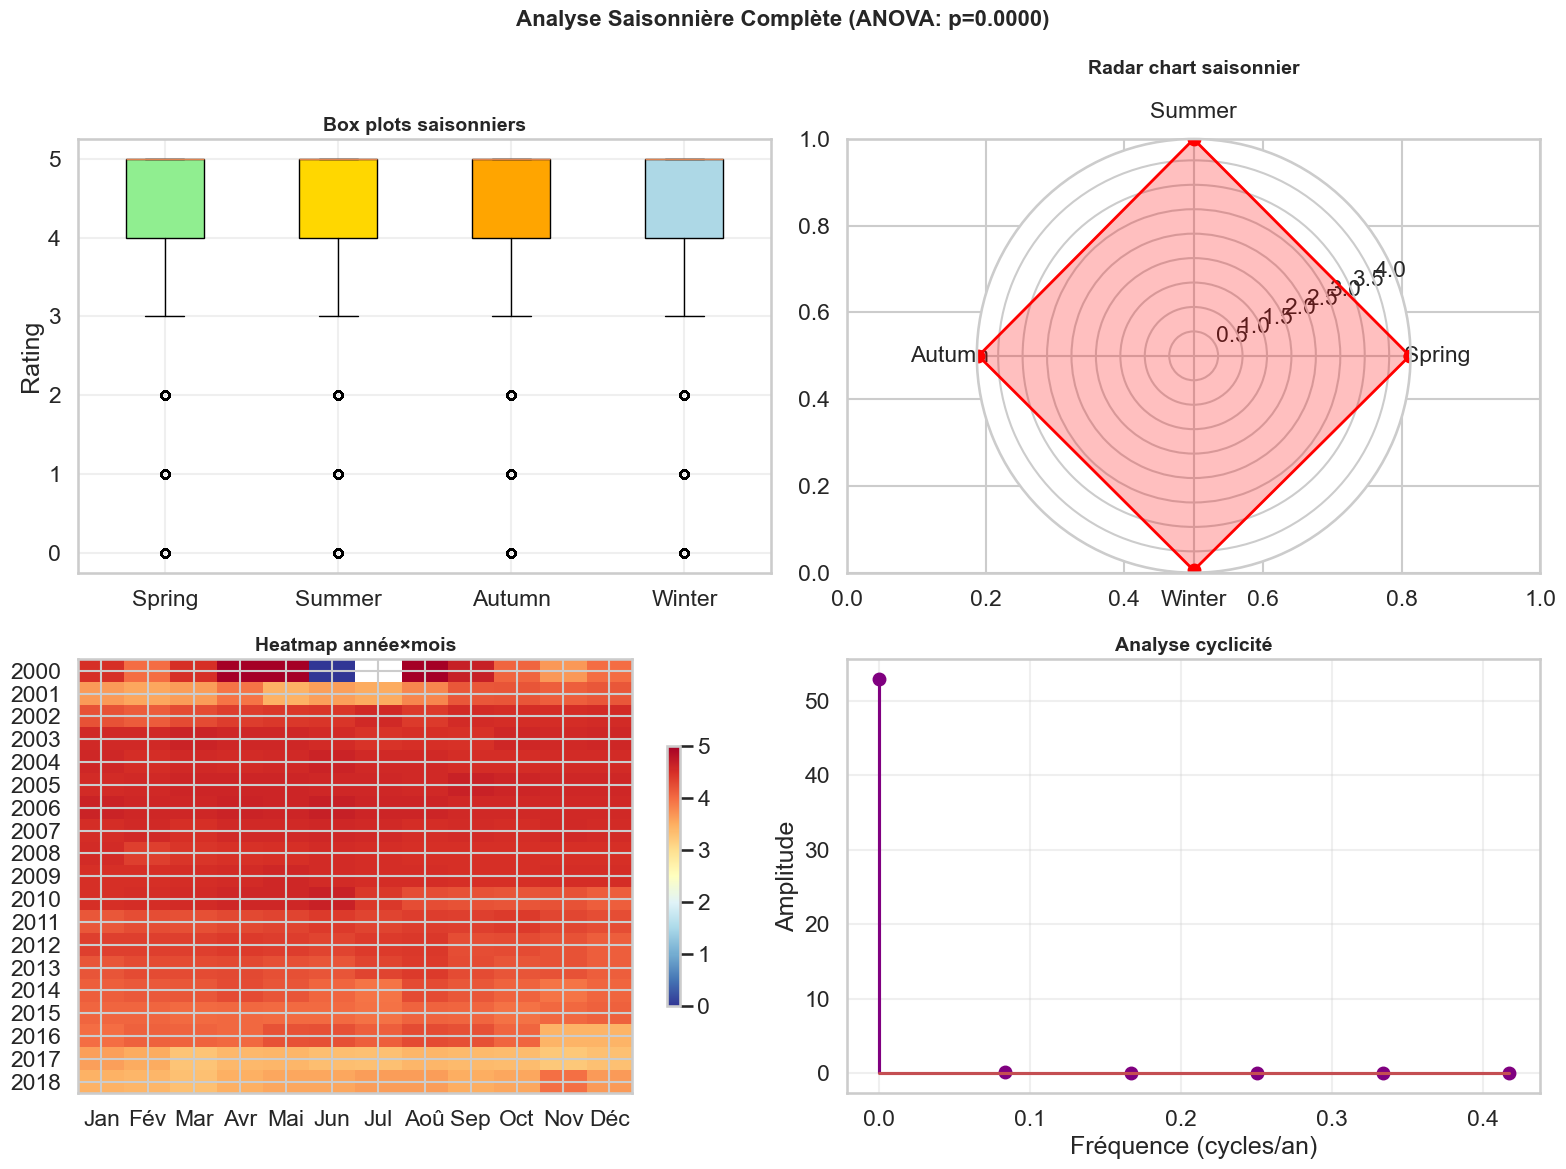


💡 Insights saisonniers:
• Écart saisonnier: 0.0462 points
• Effet saison: SIGNIFICATIF
• Hypothèse hiver/été: Confirmée
• Saison la plus stable: Summer
• Saison la plus polarisée: Winter


In [19]:
# Visualisations saisonnières complètes avec Matplotlib
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Box plots par saison
season_colors = {"Spring": "lightgreen", "Summer": "gold", "Autumn": "orange", "Winter": "lightblue"}
season_data_lists = []
season_labels = []
colors_list = []

for season in season_order:
    season_data = df_clean.filter(pl.col("season") == season)["rating"].to_pandas().tolist()
    season_data_lists.append(season_data)
    season_labels.append(season)
    colors_list.append(season_colors[season])

box_plot = ax1.boxplot(season_data_lists, labels=season_labels, patch_artist=True)
for patch, color in zip(box_plot['boxes'], colors_list):
    patch.set_facecolor(color)
ax1.set_title("Box plots saisonniers", fontsize=14, fontweight='bold')
ax1.set_ylabel("Rating")
ax1.grid(True, alpha=0.3)

# 2. Radar chart saisonnier (approximation avec plot polaire)
import numpy as np
theta = np.linspace(0, 2*np.pi, len(seasonal_ratings), endpoint=False)
theta = np.concatenate((theta, [theta[0]]))  # Fermer le cercle
values = np.concatenate((seasonal_ratings["mean_rating"].values, [seasonal_ratings["mean_rating"].values[0]]))

ax2 = plt.subplot(2, 2, 2, projection='polar')
ax2.plot(theta, values, 'ro-', linewidth=2, color='red')
ax2.fill(theta, values, alpha=0.25, color='red')
ax2.set_xticks(theta[:-1])
ax2.set_xticklabels(seasonal_ratings["season"])
ax2.set_title("Radar chart saisonnier", fontsize=14, fontweight='bold', pad=20)

# 3. Heatmap année×mois
year_month_grid = df_clean.group_by(["year", "month"]).agg([
    pl.col("rating").mean().alias("mean_rating"),
    pl.len().alias("n_interactions")
]).to_pandas()

# Pivot pour heatmap
heatmap_data = year_month_grid.pivot(index='year', columns='month', values='mean_rating')
month_names = ["Jan", "Fév", "Mar", "Avr", "Mai", "Jun", "Jul", "Aoû", "Sep", "Oct", "Nov", "Déc"]

im = ax3.imshow(heatmap_data.values, cmap='RdYlBu_r', aspect='auto')
ax3.set_xticks(range(len(heatmap_data.columns)))
ax3.set_xticklabels([month_names[i-1] for i in heatmap_data.columns])
ax3.set_yticks(range(len(heatmap_data.index)))
ax3.set_yticklabels(heatmap_data.index)
ax3.set_title("Heatmap année×mois", fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax3, shrink=0.6)

# 4. Analyse FFT cyclicité
monthly_series = df_clean.group_by("month").agg(
    pl.col("rating").mean().alias("mean_rating")
).sort("month").to_pandas()["mean_rating"].values

# FFT pour détecter cycles
from scipy.fft import fft, fftfreq
fft_values = np.abs(fft(monthly_series))
frequencies = fftfreq(len(monthly_series))

ax4.stem(frequencies[:len(frequencies)//2], fft_values[:len(fft_values)//2], linefmt='purple')
ax4.set_title("Analyse cyclicité", fontsize=14, fontweight='bold')
ax4.set_xlabel("Fréquence (cycles/an)")
ax4.set_ylabel("Amplitude")
ax4.grid(True, alpha=0.3)

plt.suptitle(f"Analyse Saisonnière Complète (ANOVA: p={p_anova:.4f})", 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n💡 Insights saisonniers:")
print(f"• Écart saisonnier: {seasonal_range:.4f} points")
print(f"• Effet saison: {'SIGNIFICATIF' if p_anova < 0.05 else 'NON SIGNIFICATIF'}")
print(f"• Hypothèse hiver/été: {'Confirmée' if (worst_season == 'Winter' and best_season in ['Summer', 'Spring']) else 'À réviser'}")
print(f"• Saison la plus stable: {seasonal_ratings.loc[seasonal_ratings['std_rating'].idxmin(), 'season']}")
print(f"• Saison la plus polarisée: {seasonal_ratings.loc[seasonal_ratings['std_rating'].idxmax(), 'season']}")

# Rating Analysis - Seasonality Effects

Analyse des effets saisonniers sur les ratings : variations mensuelles, impact des saisons, patterns cycliques.

In [7]:
# Import du module utilitaire Python (plus robuste que %run)
import sys
sys.path.append('../')

# 🎯 Chargement des fonctions utilitaires depuis le fichier Python
from data_utils import *

# Imports spécifiques à l'analyse saisonnière
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

sns.set_theme(style="whitegrid", context="talk")

print("✅ Imports terminés - Module data_utils chargé")

✅ Imports terminés - Module data_utils chargé


## 📥 Chargement et préparation

In [ ]:
# Chargement direct des données transformées (propres et enrichies)
df_enriched = load_clean_interactions()

# Focus sur les données avec ratings valides
df_rated = df_enriched.filter(pl.col("rating") > 0)

print(f"📊 Dataset: {df_rated.shape[0]:,} ratings valides")
print(f"📅 Période: {df_rated['year'].min()} - {df_rated['year'].max()}")

# Aperçu des variables calendaires
print("\n🗓️ Variables saisonnières disponibles:")
for col in ["month", "season", "is_weekend"]:
    unique_vals = df_rated.select(pl.col(col).unique().sort()).to_series().to_pandas().tolist()
    print(f"   {col}: {unique_vals}")

📊 Dataset: 1,071,520 ratings valides
📅 Période: 2000 - 2018

🗓️ Variables saisonnières disponibles:
   month: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
   season: ['Autumn', 'Spring', 'Summer', 'Winter']
   is_weekend: [0, 1]


## 🌙 Analyse mensuelle

In [9]:
# Statistiques par mois
monthly_stats = df_rated.group_by("month").agg([
    pl.col("rating").mean().alias("mean_rating"),
    pl.col("rating").median().alias("median_rating"),
    pl.col("rating").std().alias("std_rating"),
    pl.len().alias("n_ratings"),
    pl.col("rating").quantile(0.25).alias("q25"),
    pl.col("rating").quantile(0.75).alias("q75")
]).sort("month")

monthly_pd = monthly_stats.to_pandas()

# Mapping des noms de mois
month_names = {
    1: 'Jan', 2: 'Fév', 3: 'Mar', 4: 'Avr', 5: 'Mai', 6: 'Juin',
    7: 'Juil', 8: 'Août', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Déc'
}
monthly_pd['month_name'] = monthly_pd['month'].map(month_names)

print("📊 Statistiques mensuelles:")
display(monthly_pd)

📊 Statistiques mensuelles:


,month,mean_rating,median_rating,std_rating,n_ratings,q25,q75,month_name
0,1,4.644382,5.0,0.744660,104168,5.0,5.0,Jan
1,2,4.645819,5.0,0.739967,87156,5.0,5.0,Fév
2,3,4.656671,5.0,0.725503,92471,5.0,5.0,Mar
3,4,4.672150,5.0,0.699947,89050,5.0,5.0,Avr
4,5,4.677064,5.0,0.694333,85088,5.0,5.0,Mai
5,6,4.688471,5.0,0.683861,92534,5.0,5.0,Juin
6,7,4.672943,5.0,0.716365,86358,5.0,5.0,Juil
7,8,4.666194,5.0,0.713425,83932,5.0,5.0,Août
8,9,4.657110,5.0,0.722533,84339,5.0,5.0,Sep
9,10,4.652482,5.0,0.727659,90119,5.0,5.0,Oct


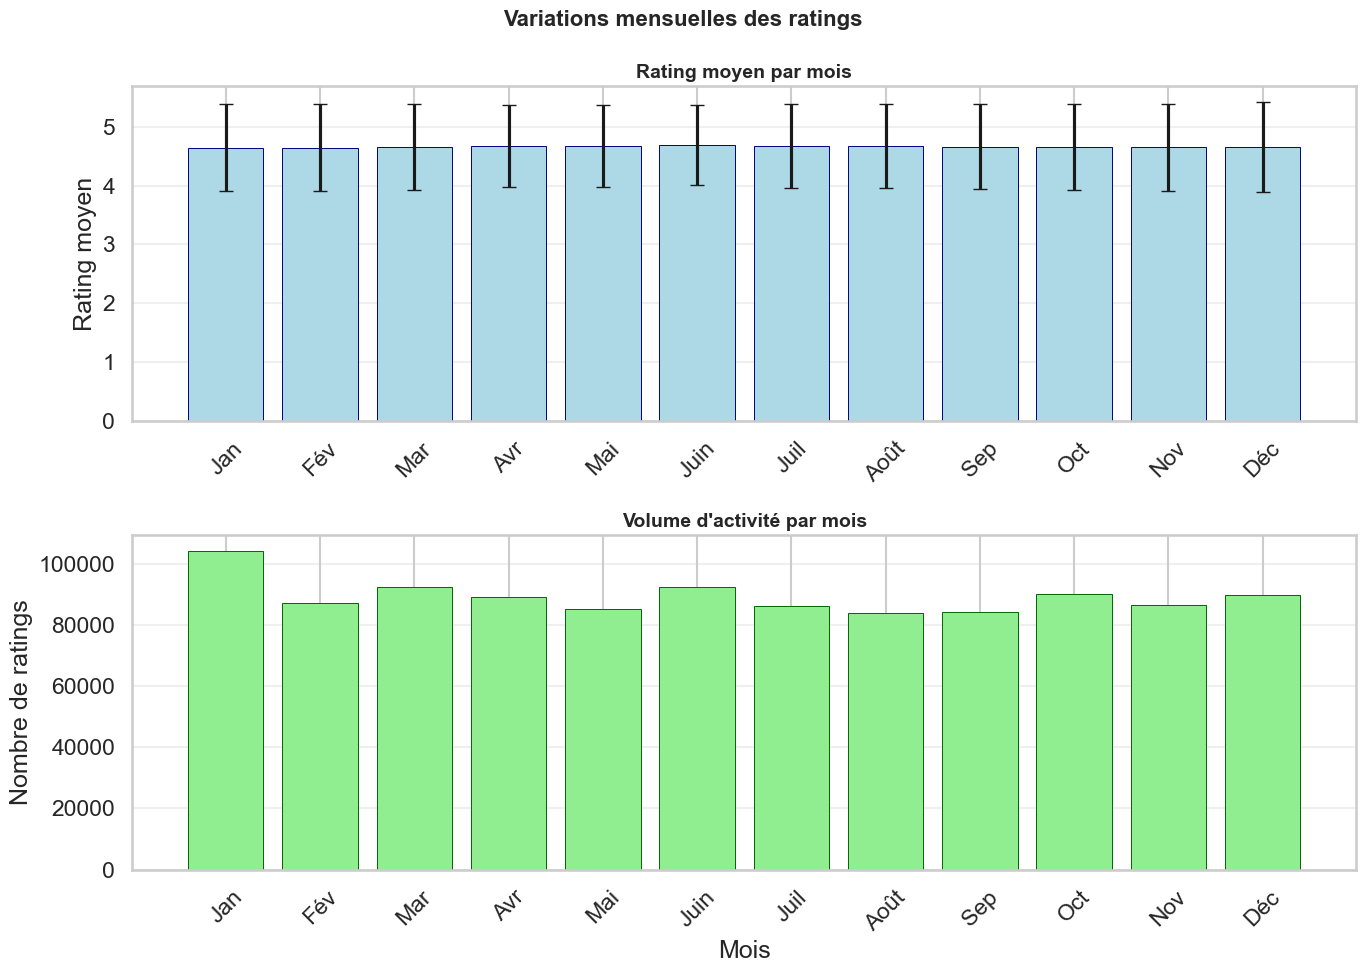

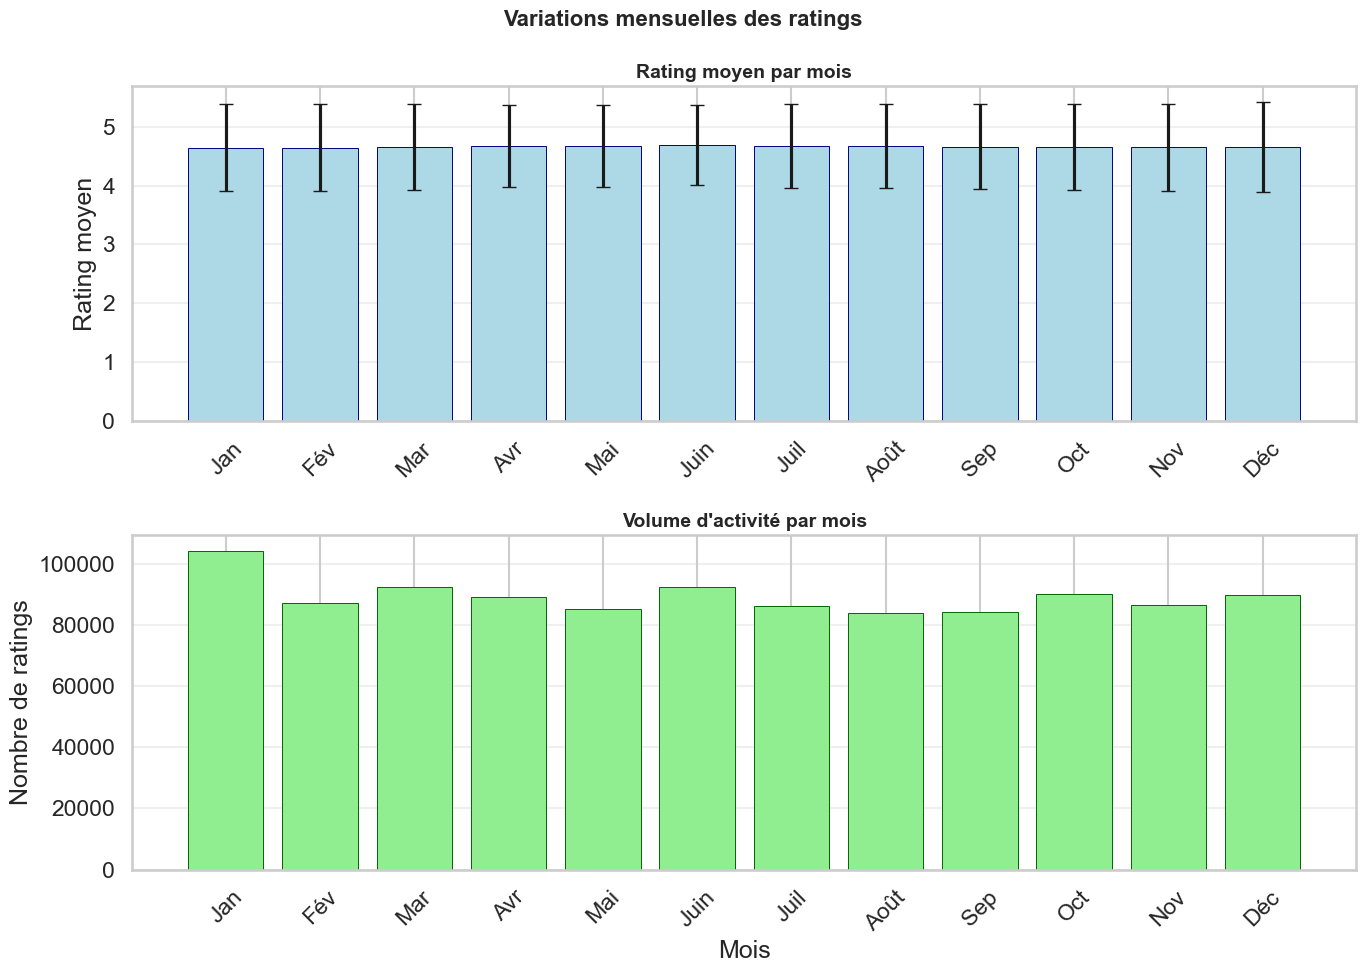

In [21]:
# Visualisation interactive mensuelle avec Matplotlib
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Rating moyen avec barres d'erreur
ax1.bar(monthly_pd['month_name'], monthly_pd['mean_rating'], 
        yerr=monthly_pd['std_rating'], capsize=5, 
        color='lightblue', edgecolor='navy', linewidth=0.7)
ax1.set_title('Rating moyen par mois', fontsize=14, fontweight='bold')
ax1.set_ylabel('Rating moyen')
ax1.grid(True, alpha=0.3, axis='y')
ax1.tick_params(axis='x', rotation=45)

# Volume d'activité
ax2.bar(monthly_pd['month_name'], monthly_pd['n_ratings'], 
        color='lightgreen', edgecolor='darkgreen', linewidth=0.7)
ax2.set_title('Volume d\'activité par mois', fontsize=14, fontweight='bold')
ax2.set_ylabel('Nombre de ratings')
ax2.set_xlabel('Mois')
ax2.grid(True, alpha=0.3, axis='y')
ax2.tick_params(axis='x', rotation=45)

plt.suptitle("Variations mensuelles des ratings", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Rating moyen avec barres d'erreur
ax1.bar(monthly_pd['month_name'], monthly_pd['mean_rating'], 
        yerr=monthly_pd['std_rating'], capsize=5, 
        color='lightblue', edgecolor='navy', linewidth=0.7)
ax1.set_title('Rating moyen par mois', fontsize=14, fontweight='bold')
ax1.set_ylabel('Rating moyen')
ax1.grid(True, alpha=0.3, axis='y')
ax1.tick_params(axis='x', rotation=45)

# Volume d'activité
ax2.bar(monthly_pd['month_name'], monthly_pd['n_ratings'], 
        color='lightgreen', edgecolor='darkgreen', linewidth=0.7)
ax2.set_title('Volume d\'activité par mois', fontsize=14, fontweight='bold')
ax2.set_ylabel('Nombre de ratings')
ax2.set_xlabel('Mois')
ax2.grid(True, alpha=0.3, axis='y')
ax2.tick_params(axis='x', rotation=45)

plt.suptitle("Variations mensuelles des ratings", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 🌸 Analyse saisonnière

In [ ]:
# Statistiques par saison
seasonal_stats = df_rated.group_by("season").agg([
    pl.col("rating").mean().alias("mean_rating"),
    pl.col("rating").median().alias("median_rating"),
    pl.col("rating").std().alias("std_rating"),
    pl.len().alias("n_ratings")
]).sort("season")

seasonal_pd = seasonal_stats.to_pandas()

print("🌸 Statistiques saisonnières:")
display(seasonal_pd)

# Test ANOVA pour différences saisonnières
season_groups = []
for season in seasonal_pd['season']:
    ratings = df_rated.filter(pl.col("season") == season).select("rating").to_series()
    season_groups.append(ratings.to_pandas().tolist())

f_stat, p_value = stats.f_oneway(*season_groups)

print(f"\n📊 Test ANOVA saisonnier:")
print(f"   F-statistic: {f_stat:.4f}")
print(f"   p-value: {p_value:.4f}")

if p_value < 0.05:
    print(f"   ✅ Différences saisonnières significatives")
else:
    print(f"   ❌ Pas de différence saisonnière significative")

🌸 Statistiques saisonnières:


,season,mean_rating,median_rating,std_rating,n_ratings
0,Autumn,4.654258,5.0,0.730149,261007
1,Spring,4.668350,5.0,0.707203,266609
2,Summer,4.676255,5.0,0.704200,262824
3,Winter,4.647926,5.0,0.747944,281080



📊 Test ANOVA saisonnier:
   F-statistic: 86.2253
   p-value: 0.0000
   ✅ Différences saisonnières significatives


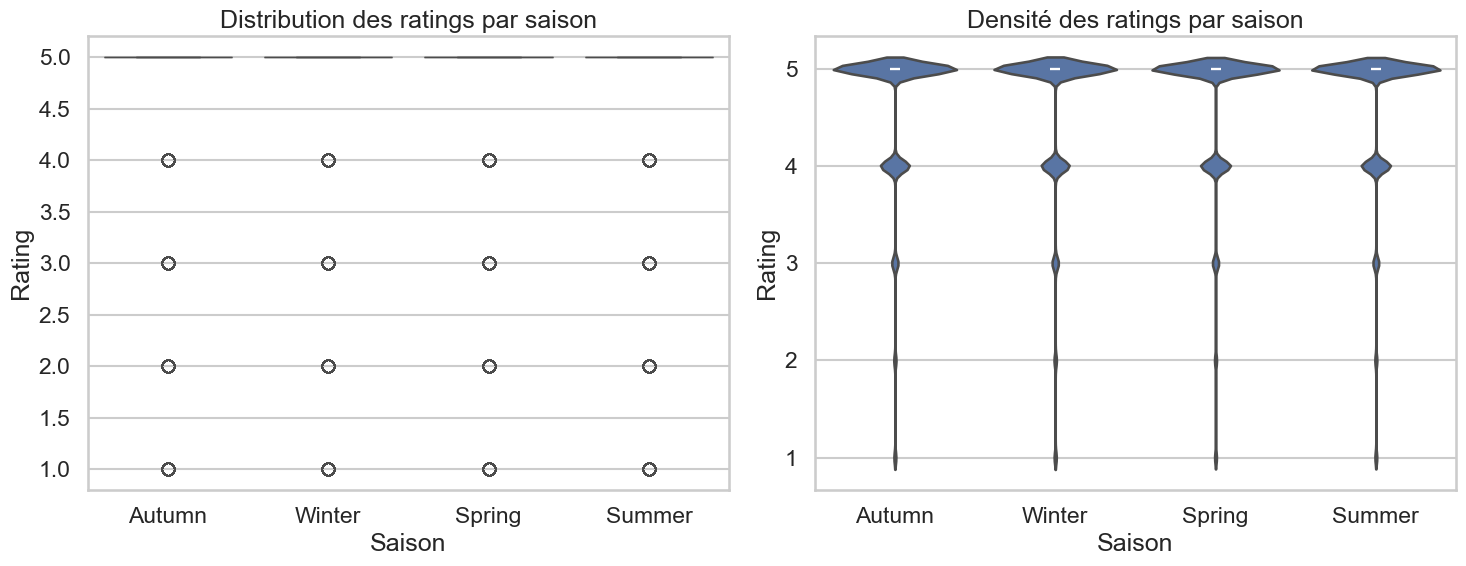

In [12]:
# Box plots saisonniers
seasonal_data = df_rated.select(["season", "rating"]).to_pandas()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Box plot des ratings par saison
sns.boxplot(data=seasonal_data, x='season', y='rating', ax=ax1)
ax1.set_title('Distribution des ratings par saison')
ax1.set_ylabel('Rating')
ax1.set_xlabel('Saison')

# Violin plot pour voir la densité
sns.violinplot(data=seasonal_data, x='season', y='rating', ax=ax2)
ax2.set_title('Densité des ratings par saison')
ax2.set_ylabel('Rating')
ax2.set_xlabel('Saison')

plt.tight_layout()
plt.show()

## 🎯 Heatmap saisonnière

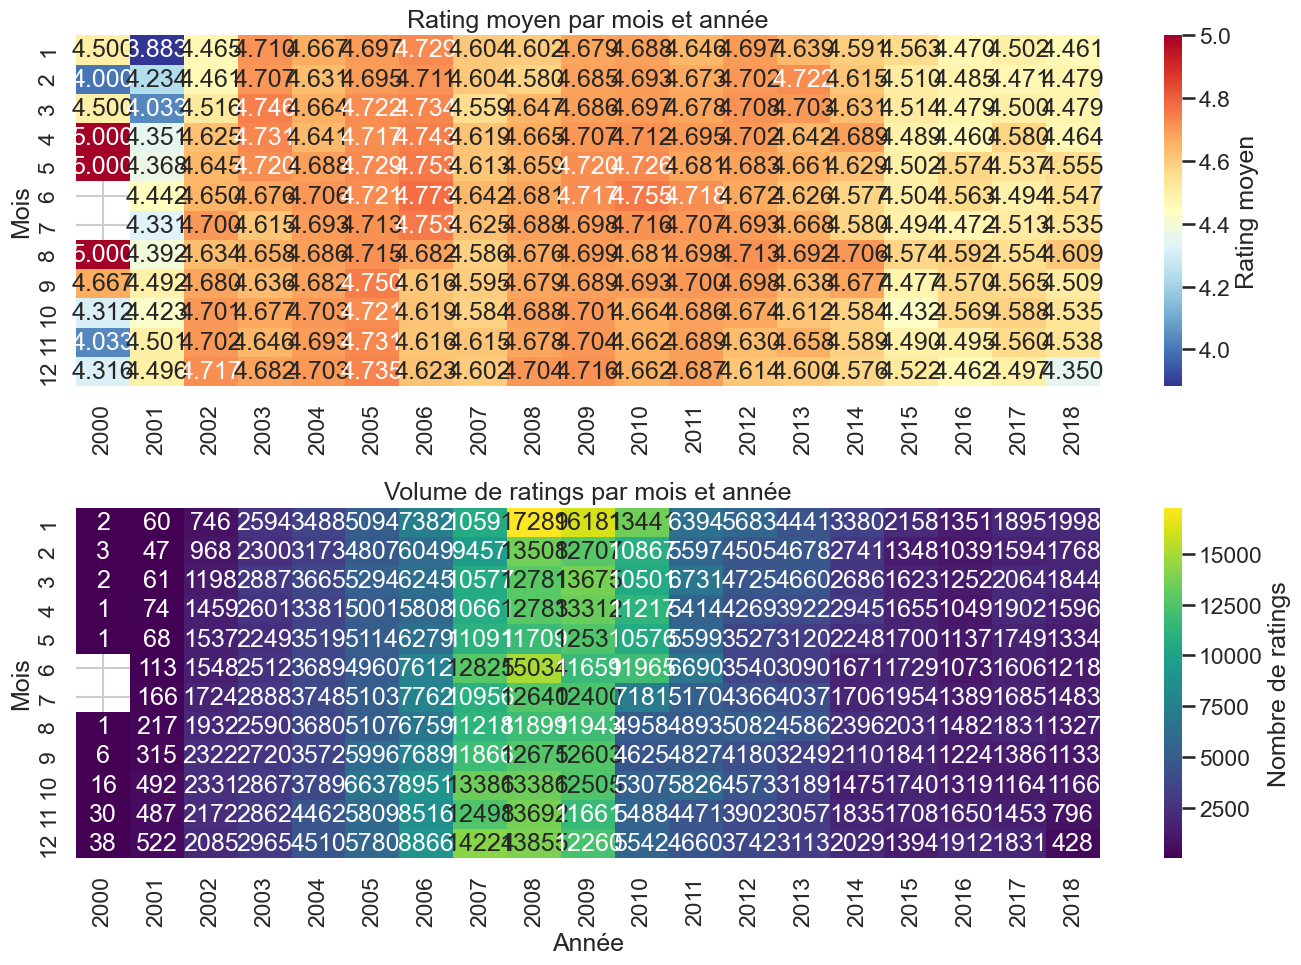

In [13]:
# Création d'une heatmap mois x année
monthly_yearly = df_rated.group_by(["year", "month", "season"]).agg([
    pl.col("rating").mean().alias("mean_rating"),
    pl.len().alias("n_ratings")
]).to_pandas()

# Pivot pour la heatmap
heatmap_data = monthly_yearly.pivot(index='month', columns='year', values='mean_rating')
volume_data = monthly_yearly.pivot(index='month', columns='year', values='n_ratings')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Heatmap des ratings moyens
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlBu_r', 
           ax=ax1, cbar_kws={'label': 'Rating moyen'})
ax1.set_title('Rating moyen par mois et année')
ax1.set_ylabel('Mois')
ax1.set_xlabel('')

# Heatmap du volume
sns.heatmap(volume_data, annot=True, fmt='.0f', cmap='viridis', 
           ax=ax2, cbar_kws={'label': 'Nombre de ratings'})
ax2.set_title('Volume de ratings par mois et année')
ax2.set_ylabel('Mois')
ax2.set_xlabel('Année')

plt.tight_layout()
plt.show()

## 🔍 Analyse cyclique avancée

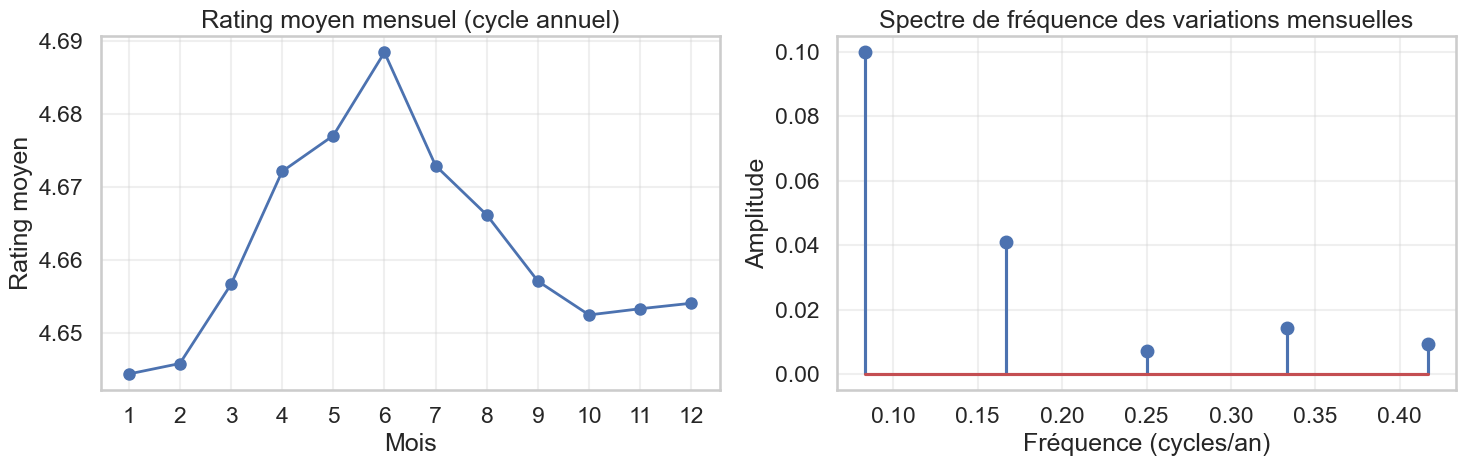

📊 Analyse cyclique:
   Fréquence principale: 0.0833 cycles/an
   Période principale: 12.0 mois
   ✅ Cycle annuel détecté


In [14]:
# Test de cyclicité avec transformée de Fourier
import numpy as np
from scipy.fft import fft, fftfreq

# Préparation des données mensuelles ordonnées
monthly_series = monthly_pd.sort_values('month')['mean_rating'].values

# Application de la FFT
fft_values = fft(monthly_series)
frequencies = fftfreq(len(monthly_series))

# Amplitude des composantes de fréquence
amplitudes = np.abs(fft_values)

# Graphique de la cyclicité
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Série temporelle mensuelle
ax1.plot(monthly_pd['month'], monthly_pd['mean_rating'], 'o-', linewidth=2, markersize=8)
ax1.set_title('Rating moyen mensuel (cycle annuel)')
ax1.set_xlabel('Mois')
ax1.set_ylabel('Rating moyen')
ax1.set_xticks(range(1, 13))
ax1.grid(True, alpha=0.3)

# Spectre de fréquence (sans la composante DC)
ax2.stem(frequencies[1:len(frequencies)//2], amplitudes[1:len(amplitudes)//2])
ax2.set_title('Spectre de fréquence des variations mensuelles')
ax2.set_xlabel('Fréquence (cycles/an)')
ax2.set_ylabel('Amplitude')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Identification du pic principal
main_freq_idx = np.argmax(amplitudes[1:len(amplitudes)//2]) + 1
main_frequency = frequencies[main_freq_idx]
main_period = 1 / abs(main_frequency) if main_frequency != 0 else float('inf')

print(f"📊 Analyse cyclique:")
print(f"   Fréquence principale: {main_frequency:.4f} cycles/an")
print(f"   Période principale: {main_period:.1f} mois")

if 10 <= main_period <= 14:
    print(f"   ✅ Cycle annuel détecté")
elif 5 <= main_period <= 7:
    print(f"   🔄 Cycle semestriel détecté")
else:
    print(f"   ⚠️ Cycle atypique")

## 📈 Test de Kruskal-Wallis mensuel

In [ ]:
# Test non-paramétrique pour différences mensuelles
monthly_groups = []
for month in range(1, 13):
    ratings = df_rated.filter(pl.col("month") == month).select("rating").to_series()
    if len(ratings) > 0:
        monthly_groups.append(ratings.to_pandas().tolist())

h_stat, p_value_kw = stats.kruskal(*monthly_groups)

print(f"📊 Test de Kruskal-Wallis (mensuel):")
print(f"   H-statistic: {h_stat:.4f}")
print(f"   p-value: {p_value_kw:.4f}")
print(f"   Degrés de liberté: {len(monthly_groups) - 1}")

if p_value_kw < 0.05:
    print(f"   ✅ Différences mensuelles significatives")
    
    # Post-hoc: comparaisons par paires
    print(f"\n🔍 Analyse post-hoc (comparaisons significatives):")
    
    significant_pairs = []
    for i, month1 in enumerate(range(1, 13)):
        for month2 in range(month1 + 1, 13):
            group1 = df_rated.filter(pl.col("month") == month1).select("rating").to_series().to_pandas().tolist()
            group2 = df_rated.filter(pl.col("month") == month2).select("rating").to_series().to_pandas().tolist()
            
            if len(group1) > 0 and len(group2) > 0:
                _, p_pair = stats.mannwhitneyu(group1, group2, alternative='two-sided')
                
                # Correction de Bonferroni
                p_corrected = p_pair * 66  # 12*11/2 comparaisons
                
                if p_corrected < 0.05:
                    mean1 = np.mean(group1)
                    mean2 = np.mean(group2)
                    significant_pairs.append((month1, month2, mean1, mean2, p_corrected))
    
    if significant_pairs:
        for month1, month2, mean1, mean2, p_corr in significant_pairs[:5]:  # Top 5
            diff = abs(mean1 - mean2)
            print(f"   {month_names[month1]} vs {month_names[month2]}: Δ={diff:.4f} (p={p_corr:.4f})")
    else:
        print(f"   Aucune paire significative après correction")
        
else:
    print(f"   ❌ Pas de différence mensuelle significative")

📊 Test de Kruskal-Wallis (mensuel):
   H-statistic: 283.3005
   p-value: 0.0000
   Degrés de liberté: 11
   ✅ Différences mensuelles significatives

🔍 Analyse post-hoc (comparaisons significatives):
   Jan vs Avr: Δ=0.0278 (p=0.0000)
   Jan vs Mai: Δ=0.0327 (p=0.0000)
   Jan vs Juin: Δ=0.0441 (p=0.0000)
   Jan vs Juil: Δ=0.0286 (p=0.0000)
   Jan vs Août: Δ=0.0218 (p=0.0000)
   Jan vs Avr: Δ=0.0278 (p=0.0000)
   Jan vs Mai: Δ=0.0327 (p=0.0000)
   Jan vs Juin: Δ=0.0441 (p=0.0000)
   Jan vs Juil: Δ=0.0286 (p=0.0000)
   Jan vs Août: Δ=0.0218 (p=0.0000)
